In [10]:
import numpy as np
import pandas as pd


import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

df = pd.read_csv('housing.csv', header=0)
l = len(df)
df


longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0        -122.23     37.88                41.0        880.0           129.0   
1        -122.22     37.86                21.0       7099.0          1106.0   
2        -122.24     37.85                52.0       1467.0           190.0   
3        -122.25     37.85                52.0       1274.0           235.0   
4        -122.25     37.85                52.0       1627.0           280.0   
...          ...       ...                 ...          ...             ...   
20635    -121.09     39.48                25.0       1665.0           374.0   
20636    -121.21     39.49                18.0        697.0           150.0   
20637    -121.22     39.43                17.0       2254.0           485.0   
20638    -121.32     39.43                18.0       1860.0           409.0   
20639    -121.24     39.37                16.0       2785.0           616.0   

       population  households  median_income  median_house_value  \
0           322.0       126.0         8.3252            452600.0   
1          2401.0      1138.0         8.3014            358500.0   
2           496.0       177.0         7.2574            352100.0   
3           558.0       219.0         5.6431            341300.0   
4           565.0       259.0         3.8462            342200.0   
...           ...         ...            ...                 ...   
20635       845.0       330.0         1.5603             78100.0   
20636       356.0       114.0         2.5568             77100.0   
20637      1007.0       433.0         1.7000             92300.0   
20638       741.0       349.0         1.8672             84700.0   
20639      1387.0       530.0         2.3886             89400.0   

      ocean_proximity  
0            NEAR BAY  
1            NEAR BAY  
2            NEAR BAY  
3            NEAR BAY  
4            NEAR BAY  
...               ...  
20635          INLAND  
20636          INLAND  
20637          INLAND  
20638          INLAND  
20639          INLAND  

[20640 rows x 10 columns]

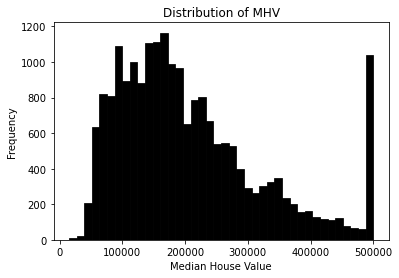

In [11]:
#median_house_value: does it have a long tail distribution?

plt.figure(figsize=(6, 4))

sns.histplot(df.median_house_value, bins=40, color='black', alpha=1)
plt.ylabel('Frequency')
plt.xlabel('Median House Value')
plt.title('Distribution of MHV')

plt.show()

In [17]:
#there's a simil-poisson distribution, with an  outlier on the max. [probably a max cap added, so every house with MHV>500k, capped at 500k]

#now, find all columns with missing (null) values:

#Question 1: Number of missing values

df.isnull().sum()


longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [18]:
#only "total bedrooms" looks like has missing values

#find the median for population:
#Question 2: Median for population 

df.population.median()

1166.0

In [42]:
#select only the field we're going to use for this workbook:
base = [
    'latitude',
    'longitude',
    'housing_median_age',
    'total_rooms',
    'total_bedrooms',
    'population',
    'households',
    'median_income',
    'median_house_value'
]

df_num = df[base]

#shuffle the set
#split the set (60/20/20) - Train/Validate/Test

np.random.seed(42)

n = len(df_num)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df_num.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

y_train_orig = df_train.median_house_value.values
y_val_orig = df_val.median_house_value.values
y_test_orig = df_test.median_house_value.values


y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

# Make sure that the target value ('median_house_value') is not in your dataframe.

df_train_def = df_train.drop(columns=['median_house_value'])
df_val_def = df_val.drop(columns=['median_house_value'])
df_test_def = df_test.drop(columns=['median_house_value'])



In [49]:
#best option to fill missing value: 0 or mean?

#get the mean from the train set
#Question 3: Best way to fill NAs 

train_mean = df_train_def.mean(axis=0)
tot_bedrooms_mean = train_mean['total_bedrooms']


def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

def prepare_X(df, fillable):
    df_num = df.fillna(fillable)
    X = df_num.values
    return X

def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

print('===== fillna with mean =====')
X_train = prepare_X(df_train_def,tot_bedrooms_mean )
w_0, w = train_linear_regression(X_train, y_train)

y_pred = w_0 + X_train.dot(w)

print('rmse train', round(rmse(y_train, y_pred),2))
#check the fillna
#X_train[:,4]

X_val = prepare_X(df_val_def, tot_bedrooms_mean)
y_pred_val = w_0 + X_val.dot(w)

print('rmse validation', round(rmse(y_val, y_pred_val),2))
print('=========================')

print('===== fillna with 0 =====')
X_train = prepare_X(df_train_def,0 )
w_0, w = train_linear_regression(X_train, y_train)

y_pred = w_0 + X_train.dot(w)

print('rmse train', round(rmse(y_train, y_pred),2))
#check the fillna
#X_train[:,4]

X_val = prepare_X(df_val_def, 0)
y_pred_val = w_0 + X_val.dot(w)

print('rmse validation', round(rmse(y_val, y_pred_val),2))
print('=========================')


===== fillna with mean =====
rmse train 0.34
rmse validation 0.33
===== fillna with 0 =====
rmse train 0.34
rmse validation 0.33


In [51]:
#Question 4: Best regularization parameter r

def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]


w_0, w = train_linear_regression_reg(X_train, y_train)

y_pred = w_0 + X_train.dot(w)


X_train = prepare_X(df_train_def,0 )
X_val = prepare_X(df_val_def,0)

for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w_0, w = train_linear_regression_reg(X_train, y_train, r=r)
    y_pred = w_0 + X_val.dot(w)
    print('%6s' %r, round(rmse(y_val, y_pred),2))


     0 0.33
 1e-06 0.33
0.0001 0.33
 0.001 0.33
  0.01 0.33
   0.1 0.33
     1 0.33
     5 0.34
    10 0.34


In [70]:
#Question 5: STD of RMSE scores for different seeds

#select only the field we're going to use for this workbook:
base = [
    'latitude',
    'longitude',
    'housing_median_age',
    'total_rooms',
    'total_bedrooms',
    'population',
    'households',
    'median_income',
    'median_house_value'
]

df_num = df[base]

#shuffle the set
#split the set (60/20/20) - Train/Validate/Test
rmse_value = np.ones(10)
for s in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:

    np.random.seed(s)

    n = len(df_num)

    n_val = int(0.2 * n)
    n_test = int(0.2 * n)
    n_train = n - (n_val + n_test)

    idx = np.arange(n)
    np.random.shuffle(idx)

    df_shuffled = df_num.iloc[idx]

    df_train = df_shuffled.iloc[:n_train].copy()
    df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
    df_test = df_shuffled.iloc[n_train+n_val:].copy()

    y_train_orig = df_train.median_house_value.values
    y_val_orig = df_val.median_house_value.values
    y_test_orig = df_test.median_house_value.values

    y_train = np.log1p(df_train.median_house_value.values)
    y_val = np.log1p(df_val.median_house_value.values)
    y_test = np.log1p(df_test.median_house_value.values)

    # Make sure that the target value ('median_house_value') is not in your dataframe.

    df_train_def = df_train.drop(columns=['median_house_value'])
    df_val_def = df_val.drop(columns=['median_house_value'])
    df_test_def = df_test.drop(columns=['median_house_value'])



    X_train = prepare_X(df_train_def,0 )
    w_0, w = train_linear_regression(X_train, y_train)
    y_pred = w_0 + X_train.dot(w)


    X_val = prepare_X(df_val_def, 0)
    y_pred_val = w_0 + X_val.dot(w)
    print('rmse validation', round(rmse(y_val, y_pred_val),4))
    
    rmse_value[s]=rmse(y_val, y_pred_val)
    standard_dev =round(np.std(rmse_value),3)
    
    print('std dev at ',s,': ',standard_dev)
    print(rmse_value)
    print('=========================')


rmse validation 0.3388
std dev at  0 :  0.198
[0.33884305 1.         1.         1.         1.         1.
 1.         1.         1.         1.        ]
rmse validation 0.3362
std dev at  1 :  0.265
[0.33884305 0.33623873 1.         1.         1.         1.
 1.         1.         1.         1.        ]
rmse validation 0.3321
std dev at  2 :  0.304
[0.33884305 0.33623873 0.33209123 1.         1.         1.
 1.         1.         1.         1.        ]
rmse validation 0.3405
std dev at  3 :  0.325
[0.33884305 0.33623873 0.33209123 0.34051536 1.         1.
 1.         1.         1.         1.        ]
rmse validation 0.3389
std dev at  4 :  0.331
[0.33884305 0.33623873 0.33209123 0.34051536 0.33890241 1.
 1.         1.         1.         1.        ]
rmse validation 0.3435
std dev at  5 :  0.324
[0.33884305 0.33623873 0.33209123 0.34051536 0.33890241 0.34348667
 1.         1.         1.         1.        ]
rmse validation 0.3452
std dev at  6 :  0.303
[0.33884305 0.33623873 0.33209123 0.3405

In [78]:
#Question 6: RMSE on test 

    np.random.seed(9)

    n = len(df_num)

    n_val = int(0.2 * n)
    n_test = int(0.2 * n)
    n_train = n - (n_val + n_test)

    idx = np.arange(n)
    np.random.shuffle(idx)

    df_shuffled = df_num.iloc[idx]

    df_train = df_shuffled.iloc[:n_train].copy()
    df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
    df_test = df_shuffled.iloc[n_train+n_val:].copy()

    y_train_orig = df_train.median_house_value.values
    y_val_orig = df_val.median_house_value.values
    y_test_orig = df_test.median_house_value.values

    y_train = np.log1p(df_train.median_house_value.values)
    y_val = np.log1p(df_val.median_house_value.values)
    y_test = np.log1p(df_test.median_house_value.values)

    # Make sure that the target value ('median_house_value') is not in your dataframe.

    df_train_def = df_train.drop(columns=['median_house_value'])
    df_val_def = df_val.drop(columns=['median_house_value'])
    df_test_def = df_test.drop(columns=['median_house_value'])

    
    df_full_train = pd.concat([df_train_def,df_val_def])
    y_full_train = np.concatenate([y_train,y_val])
    
    X_train = prepare_X(df_full_train,0 )
    w_0, w = train_linear_regression_reg(X_train, y_full_train, r=0.001)

    X_test = prepare_X(df_test_def,0)
    y_pred = w_0 + X_test.dot(w)

    
    print('rmse validation (test)', round(rmse(y_test, y_pred),4))
    
    

rmse validation (test) 0.3453
